In [ ]:
%pip install progressbar xgboost matplotlib boto3 openpyxl tqdm hydroeval

In [1]:
# hydrological packages
import hydroeval as he
from hydrotools.nwm_client import utils # I had to pip install this

# my packages
from g_evaluation_metric import MAPE, RMSE, KGE, PBias
from s_evalaution_table import evtab
import s_FigureGenerator
from g_bidirectional_lstm import CustomBiLSTM

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# system packages
from progressbar import ProgressBar
from datetime import datetime, date
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time

# data analysis packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
if platform.system() == 'Windows':
    onedrive_path = 'E:/OneDrive/OneDrive - The University of Alabama/10.material/01.data/usgs_data/'
    box_path = 'C:/Users/snaserneisary/Box/NWM-ML/'

elif platform.system() == 'Darwin':
    onedrive_path = '/Users/savalan/Library/CloudStorage/OneDrive-TheUniversityofAlabama/02.projects/03.ciroh/04.data/'
    box_path = '/Users/savalan/Library/CloudStorage/Box-Box/NWM-ML/Data/NWM/ut/'
    
elif platform.system() == 'Linux':
    path_general = '/home/snaserneisary/01.projects/01.ciroh_p8/NWM-ML/Savalan/'
    path_model_save = f"{path_general}/03.output/03.bilstm/03.model_parameters/best_model.pkl"
    path_save_data = f"{path_general}/03.output/03.bilstm/02.data/" 
    path_save_figure = f"{path_general}/03.output/03.bilstm/01.figures"

## 2. Prepare the data.

In [3]:
raw_training_data = pd.read_csv(path_general + '03.output/raw_training_data.csv')
raw_training_data.pop('Unnamed: 0')
raw_training_data['station_id'] = raw_training_data['station_id'].astype('str')
raw_training_data.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305


In [4]:
Training_DF = raw_training_data.copy()

### Editing the features based on the feature importance should be in the next cell!!!!!!!!!!!!!!!

In [5]:
# Editing the features based on the feature importance should be done here!!!!!!!!!!!!!!!

Training_DF.drop([ 'Mean_Ann_Precip_in', 'Perc_Herbace', 'Perc_Forest',
                        'Mean_Basin_Elev_ft'], axis=1, inplace=True)


### Remove headwater stations!!!!!!!

In [6]:
headwater_stations = ['10011500', '10109000', '10113500', '10128500', '10131000', '10146400', '10150500', '10154200',
'10172700', '10172800', '10172952']
Training_DF = Training_DF[~raw_training_data['station_id'].isin(headwater_stations)]

In [7]:
Training_DF.datetime = pd.to_datetime(Training_DF.datetime)

Training_DF.head()


,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
3079,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-01,9.250000,-0.891007,-0.453991,0.0,0.0,37.0,275
3080,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-02,8.654167,-0.891007,-0.453991,0.0,0.0,36.0,276
3081,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-03,9.466667,-0.891007,-0.453991,0.0,0.0,36.0,277
3082,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-04,11.833333,-0.891007,-0.453991,0.0,0.0,36.0,278
3083,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-05,10.195833,-0.891007,-0.453991,0.0,0.0,36.0,279


In [9]:
import pandas as pd

# Sample dataset (replace this with your dataset)


df = Training_DF.copy()
n_steps = 4
df_processed = df.iloc[n_steps:].reset_index(drop=True)
# Create sequences
sequences = []
for i in range(n_steps, len(df)):
    sequence = df['flow_cfs'].values[i - n_steps:i]
    sequences.append(sequence)

# Convert sequences to DataFrame
sequences_df = pd.DataFrame(sequences, columns=[f'flow_cfs(t-{n_steps-i})' for i in range(n_steps)])
# Adjust column names as needed, e.g., 'A(t-2)', 'A(t-1)', 'A(t)' for n_steps = 3

# Concatenate sequences DataFrame with processed DataFrame
#df_concatenated_1 = pd.concat([sequences_df.reset_index(drop=True), df_processed], axis=1)
df_concatenated = pd.concat([sequences_df.reset_index(drop=True), df_processed], axis=1)

# # Number of future timesteps to predict
# n_steps = 30  # Adjust this according to your requirement

# # Remove every 2 rows to prepare for predicting future 2 steps
# df_processed_1 = df_concatenated_1.iloc[::3]

# # Create sequences for predicting future 2 steps
# sequences = []
# for i in range(len(df_processed_1) - n_steps):
#     sequence = df_concatenated_1['NWM_flow'].values[i*n_steps+1:i*n_steps+1 + n_steps]
#     sequences.append(sequence)

# # Convert sequences to DataFrame
# sequences_df = pd.DataFrame(sequences, columns=[f'NWM_flow(t+{i+1})' for i in range(n_steps)])
# # Adjust column names as needed, e.g., 'A(t+1)', 'A(t+2)' for n_steps = 2

# # Concatenate sequences DataFrame with processed DataFrame
# df_concatenated = pd.concat([df_processed_1.reset_index(drop=True), sequences_df], axis=1)

# # Resulting DataFrame with sequences as input features and future 2 steps for prediction
# df_concatenated.dropna(inplace=True)
# df_concatenated.drop(columns=['NWM_flow'], inplace=True)
df_concatenated

,flow_cfs(t-4),flow_cfs(t-3),flow_cfs(t-2),flow_cfs(t-1),station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
0,9.250000,8.654167,9.466667,11.833333,10105900,41.575490,-111.85522,180.0,1.01,0.0653,44.20,1992-10-05,10.195833,-0.891007,-0.453991,0.0,0.0,36.0,279
1,8.654167,9.466667,11.833333,10.195833,10105900,41.575490,-111.85522,180.0,1.01,0.0653,44.20,1992-10-06,11.033334,-0.891007,-0.453991,0.0,0.0,36.0,280
2,9.466667,11.833333,10.195833,11.033334,10105900,41.575490,-111.85522,180.0,1.01,0.0653,44.20,1992-10-07,14.166667,-0.891007,-0.453991,0.0,0.0,36.0,281
3,11.833333,10.195833,11.033334,14.166667,10105900,41.575490,-111.85522,180.0,1.01,0.0653,44.20,1992-10-08,14.875000,-0.891007,-0.453991,0.0,0.0,36.0,282
4,10.195833,11.033334,14.166667,14.875000,10105900,41.575490,-111.85522,180.0,1.01,0.0653,44.20,1992-10-09,15.625000,-0.891007,-0.453991,0.0,0.0,36.0,283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134343,167.406250,166.666670,167.770830,168.750000,10171000,40.733557,-111.92327,3430.0,14.70,4.3700,4.94,2020-09-26,169.843750,-0.529919,-0.848048,0.0,0.0,3182.0,270
134344,166.666670,167.770830,168.750000,169.843750,10171000,40.733557,-111.92327,3430.0,14.70,4.3700,4.94,2020-09-27,169.802080,-0.529919,-0.848048,0.0,0.0,3180.0,271
134345,167.770830,168.750000,169.843750,169.802080,10171000,40.733557,-111.92327,3430.0,14.70,4.3700,4.94,2020-09-28,169.833330,-0.529919,-0.848048,0.0,0.0,3179.0,272
134346,168.750000,169.843750,169.802080,169.833330,10171000,40.733557,-111.92327,3430.0,14.70,4.3700,4.94,2020-09-29,167.812500,-0.529919,-0.848048,0.0,0.0,3178.0,273


In [10]:
df_concatenated.shape

(134348, 19)

### 2.1. Create the training dataset.

In [11]:
# Training is from 1980 to the end of 2015.
Training_DF = df_concatenated
x_train_temp = Training_DF[Training_DF.datetime < '01-01-2015']
x_train_temp.pop('station_id')
x_train_temp.pop('datetime')
y_train_temp = x_train_temp['flow_cfs']
x_train_temp.pop('flow_cfs')
x_train_temp.head()

,flow_cfs(t-4),flow_cfs(t-3),flow_cfs(t-2),flow_cfs(t-1),Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY
0,9.250000,8.654167,9.466667,11.833333,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,279
1,8.654167,9.466667,11.833333,10.195833,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,280
2,9.466667,11.833333,10.195833,11.033334,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,281
3,11.833333,10.195833,11.033334,14.166667,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,282
4,10.195833,11.033334,14.166667,14.875000,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,283


#### 2.1.1. Scale the train inputs of the NN model

In [15]:
# First we need to convert it from pandas dataframe to a numpy array 
y_train = y_train_temp.to_numpy()
x_train = x_train_temp.to_numpy()
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
y_scaled_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_scaled_train.shape

(93295, 1)

In [19]:
# Reshape Input for LSTM Model
x_train_scaled_test = torch.Tensor(x_train_scaled).unsqueeze(1)
y_train_scaled_test = torch.Tensor(y_scaled_train).unsqueeze(1)
print('train x shape', x_train_scaled_test.shape)
print('train y shape', y_train_scaled_test.shape)

train x shape torch.Size([93295, 1, 16])
train y shape torch.Size([93295, 1, 1])


In [14]:
x_train_scaled_test[:10, :, 1]

tensor([[0.0013],
        [0.0015],
        [0.0018],
        [0.0016],
        [0.0017],
        [0.0022],
        [0.0023],
        [0.0024],
        [0.0022],
        [0.0029]])

### 2.2. Create the test dataset. 

In [12]:
# Determining the test dataset. 
x_test_temp = Training_DF[Training_DF.datetime >= '01-01-2015']
x_test_temp.head()

,flow_cfs(t-360),flow_cfs(t-359),flow_cfs(t-358),flow_cfs(t-357),flow_cfs(t-356),flow_cfs(t-355),flow_cfs(t-354),flow_cfs(t-353),flow_cfs(t-352),flow_cfs(t-351),...,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
7128,23.087500,26.712500,27.988540,27.566666,27.622917,28.295834,30.544792,28.979166,28.209375,27.300000,...,0.0653,44.2,2015-01-01,21.627083,-0.438371,0.898794,0.0,5.75,39.0,1
7129,26.712500,27.988540,27.566666,27.622917,28.295834,30.544792,28.979166,28.209375,27.300000,27.168749,...,0.0653,44.2,2015-01-02,23.531250,-0.438371,0.898794,0.0,5.75,39.0,2
7130,27.988540,27.566666,27.622917,28.295834,30.544792,28.979166,28.209375,27.300000,27.168749,27.047916,...,0.0653,44.2,2015-01-03,25.044792,-0.438371,0.898794,0.0,5.75,39.0,3
7131,27.566666,27.622917,28.295834,30.544792,28.979166,28.209375,27.300000,27.168749,27.047916,27.687500,...,0.0653,44.2,2015-01-04,26.103125,-0.438371,0.898794,0.0,5.75,39.0,4
7132,27.622917,28.295834,30.544792,28.979166,28.209375,27.300000,27.168749,27.047916,27.687500,27.855207,...,0.0653,44.2,2015-01-05,26.742708,-0.438371,0.898794,0.0,5.75,39.0,5


#### 2.2.1. Scale the test inputs of the NN model

In [13]:
# First we need to convert it from pandas dataframe to a numpy array 
x_test_temp_1 = x_test_temp.copy()
station_index_list = x_test_temp_1['station_id']
x_test_temp_1.pop('station_id')
x_test_temp_1.pop('datetime')
y_test_temp_1 = x_test_temp_1['flow_cfs']
x_test_temp_1.pop('flow_cfs')
x_test_1_np = x_test_temp_1.reset_index(drop=True).to_numpy()
y_test_1_np = y_test_temp_1.reset_index(drop=True).to_numpy()
x_test_1_scaled = scaler.fit_transform(x_test_1_np)
y_scaled_test_1 = scaler.fit_transform(y_test_1_np.reshape(-1, 1))

### 2.3. Create the validation dataset. 

In [18]:
# Create PyTorch datasets and dataloaders
X_train, X_valid, y_train, y_valid = train_test_split(x_train_scaled_test, y_train_scaled_test)

## 3. LSTM Model Preparation.

### 3.1. Create the model variables.

In [21]:
model_name='BiLSTM'
tries = 1
epochs = 100
batch_size = 50
learning_rate = 1e-4
early_stopping_patience = 0
decay = 0
input_size = x_train_scaled_test.shape[2]
output_size = 1
hidden_size = 300
num_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### 3.2. Create input data.

In [22]:
train_dataset = TensorDataset(x_train_scaled_test, y_train_scaled_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_dataset = TensorDataset(X_valid, y_valid)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

### 3.3. Run and evaluate the model
Here first we train the model and then we test it.
We do it 30 times so we have firm evaluation. 

In [23]:
start_time = time.time()

# Create variables
test_best_val = float('inf')
EvalDF = {}
SupplyEvalDF = {}
EvalDF_all = np.zeros([len(station_index_list.drop_duplicates()), 10])
SupplyEvalDF_all = np.zeros([len(station_index_list.drop_duplicates()), 17])

# Start running the model several times. 
for try_number in range(1, tries+1):

    # Create the variables. 
    EvalDF[try_number] = np.zeros([len(station_index_list.drop_duplicates()), 10])
    SupplyEvalDF[try_number] = np.zeros([len(station_index_list.drop_duplicates()), 17])
    SitesDict = {}
    val_loss_all = 0
    print(f'Trial Number {try_number} ==========================================================')
    
    # Set the optimizer, create the model, and train it. 
    bilstm_model = CustomBiLSTM(input_size, hidden_size, num_layers, output_size, device)
    bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=learning_rate, weight_decay=decay)
    model_parameters = bilstm_model.train_model(train_loader, epochs, bilstm_optimizer, early_stopping_patience, path_model_save, validation_loader)
    
    # Evaluate it for different stations. 
    for station_index, station_number in enumerate(station_index_list.drop_duplicates()):
        index = station_index_list == station_number # Finind the rows that have this station number.
        temp_x_scaled_test = torch.Tensor(x_test_1_scaled).unsqueeze(1)
        temp_y_scaled_test = torch.Tensor(y_scaled_test_1).unsqueeze(1)
        index_np = torch.tensor(index.to_numpy())
        test_dataset = TensorDataset(temp_x_scaled_test[index_np], temp_y_scaled_test[index_np])
        test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)
        
        # Evaluation
        yhat_test, val_loss = bilstm_model.evaluate_model(test_loader)
        
        # Invert scaling for actual and concat it with the rest of the dataset. 
        inv_yhat_test = scaler.inverse_transform(yhat_test.cpu().numpy())
        inv_yhat_test[inv_yhat_test<0] = 0 # THIS IS NOT CORRECT !!!!!!!!!!!!!!!
        nwm_test = pd.DataFrame(inv_yhat_test, columns=[f"{model_name}_flow"])
        Dfs = [nwm_test.reset_index(drop=True), x_test_temp[index].reset_index(drop=True)]
        Eval_DF_mine = pd.concat(Dfs, axis=1)
    
        # Get reach id for model eval.
        nhdreach = utils.crosswalk(usgs_site_codes=station_number)
        nhdreach = nhdreach['nwm_feature_id'].iloc[0]
        SitesDict[nhdreach] = Eval_DF_mine
        
        # Calculate the results. 
        prediction_columns = ['NWM_flow', f"{model_name}_flow"]
        observation_column = 'flow_cfs'
        result = evtab(Eval_DF_mine, prediction_columns, nhdreach, observation_column, model_name)
        EvalDF[try_number][station_index, :] = result[0]
        SupplyEvalDF[try_number][station_index, :] = result[1]

    # Finding the best model. 
    val_loss_all += val_loss
    val_loss_all = val_loss_all / len(station_index_list.drop_duplicates())
    if val_loss_all < test_best_val:
        test_best_val = val_loss_all
        best_model_parameters = model_parameters
        best_try = try_number
        best_output = SitesDict
    EvalDF_all = EvalDF[try_number] + EvalDF_all
    SupplyEvalDF_all = SupplyEvalDF[try_number] + SupplyEvalDF_all
        
# Calculate the average results for all of the trials. 
EvalDF_all = EvalDF_all / tries
SupplyEvalDF_all = SupplyEvalDF_all / tries

# Sort the outputs of the best model based on date. 
keys = list(best_output.keys())
for key_number in keys:
    best_output[key_number] = best_output[key_number].sort_values(by='datetime')
    
print('Run is Done!' + "Run Time:" + " %s seconds " % (time.time() - start_time))


Trial Number 1 ==========================================================
Epoch 1/100, Training Loss: 0.004119583871215582 Validation Loss: 0.021151941752633227
Epoch 2/100, Training Loss: 0.0025695369113236666 Validation Loss: 0.0204374627884592
Epoch 3/100, Training Loss: 0.0029110743198543787 Validation Loss: 0.022851073954912548
Epoch 4/100, Training Loss: 0.0014119719853624701 Validation Loss: 0.02119376850604036
Epoch 5/100, Training Loss: 0.00220577628351748 Validation Loss: 0.020671633001050564
Epoch 6/100, Training Loss: 0.0007472604629583657 Validation Loss: 0.02092321508902554
Epoch 7/100, Training Loss: 0.00144755479414016 Validation Loss: 0.020704329510850498
Epoch 8/100, Training Loss: 0.000946929503697902 Validation Loss: 0.02052405580304273
Epoch 9/100, Training Loss: 0.0008555536041967571 Validation Loss: 0.020493258730744274
Epoch 10/100, Training Loss: 0.0007027214160189033 Validation Loss: 0.02060652716549874
Epoch 11/100, Training Loss: 0.0007755595142953098 Valida

### 3.4. Create and save the final results.


In [24]:
#Evaluation columns for prediction time series
cols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{model_name}_rmse", 'NWM_pbias', f"{model_name}_pbias", 
        'NWM_kge', f"{model_name}__kge", 'NWM_mape',  f"{model_name}_mape"]

#Evaluation columns for accumulated supply time series
supcols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{model_name}_rmse", 'NWM_pbias', f"{model_name}_pbias", 
        'NWM_kge', f"{model_name}__kge", 'NWM_mape',  f"{model_name}_mape", 'Obs_vol', 'NWM_vol', f"{model_name}_vol",
        'NWM_vol_err', f"{model_name}_vol_err", 'NWM_vol_Perc_diff', f"{model_name}_vol_Perc_diff"]
    
#save model results
EvalDF_all = pd.DataFrame(EvalDF_all, columns=cols)
SupplyEvalDF_all = pd.DataFrame(SupplyEvalDF_all, columns=supcols)
EvalDF_all.to_csv(f"{path_save_data}/{model_name}_Performance.csv")   
SupplyEvalDF_all.to_csv(f"{path_save_data}/{model_name}_Supply_Performance.csv")
torch.save(best_model_parameters, path_model_save)

In [25]:
print("Model Performance for Daily cfs")
display(EvalDF_all)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF_all)


Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_rmse,BiLSTM_rmse,NWM_pbias,BiLSTM_pbias,NWM_kge,BiLSTM__kge,NWM_mape,BiLSTM_mape
0,23.087500,666170.0,90.667995,44.815004,-16.13,6.80,0.72,0.85,108.61,16.95
1,688.510440,4605050.0,1861.439475,608.807077,-53.15,7.31,0.14,0.84,369.37,37.72
2,4.569896,10093082.0,29.960617,6.199238,-210.87,69.71,-3.04,0.19,225.61,83.34
3,6.991354,10276856.0,34.537693,10.401759,-135.83,44.29,-0.56,0.53,271.07,64.92
4,10.127708,10276836.0,53.460353,18.534909,-127.58,45.49,-0.41,0.51,254.98,65.39
5,16.202084,10276712.0,97.119345,21.253139,-179.04,24.50,-0.87,0.71,382.65,38.23
6,5.450000,10277268.0,128.603024,16.494323,-235.17,14.00,-1.48,0.83,1014.93,53.33
7,53.866665,10274616.0,776.608631,129.465968,-191.07,-0.01,-0.99,0.92,436.46,19.87
8,28.141666,10274270.0,107.073089,50.982242,33.05,5.36,0.48,0.83,38.66,20.85
9,11.300000,10275828.0,270.370388,96.990830,-134.83,14.93,-0.42,0.73,813.07,43.55


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_rmse,BiLSTM_rmse,NWM_pbias,BiLSTM_pbias,NWM_kge,BiLSTM__kge,NWM_mape,BiLSTM_mape,Obs_vol,NWM_vol,BiLSTM_vol,NWM_vol_err,BiLSTM_vol_err,NWM_vol_Perc_diff,BiLSTM_vol_Perc_diff
0,23.087500,666170.0,1.432436e+04,3919.167594,-2.92,7.71,0.78,0.91,27.83,9.60,37232.679662,50915.508,35375.863281,1.368283e+04,-1856.816381,36.749513,-4.987061
1,688.510440,4605050.0,3.522460e+05,73373.338431,-28.50,9.26,0.46,0.91,50.06,11.12,655183.188796,1149487.593,556891.937500,4.943044e+05,-98291.251296,75.445221,-15.002102
2,4.569896,10093082.0,8.093940e+03,2211.638801,-219.00,63.84,-2.08,0.17,220.63,69.54,3759.072756,18822.636,1193.686279,1.506356e+04,-2565.386477,400.725504,-68.245194
3,6.991354,10276856.0,9.281958e+03,3316.415792,-94.33,38.60,-0.30,0.54,105.73,47.21,9663.116575,30161.430,5432.553223,2.049831e+04,-4230.563352,212.129423,-43.780527
4,10.127708,10276836.0,1.579701e+04,6124.666096,-93.53,41.51,-0.30,0.50,108.76,51.26,18057.498883,47800.215,10244.523438,2.974272e+04,-7812.975445,164.711161,-43.267207
5,16.202084,10276712.0,3.113292e+04,4821.930557,-133.03,22.42,-0.73,0.73,155.75,27.52,23337.537876,78025.101,17725.335938,5.468756e+04,-5612.201939,234.333045,-24.047961
6,5.450000,10277268.0,4.855101e+04,3417.916067,-279.98,20.46,-2.35,0.77,876.92,50.68,37262.276126,96970.683,31372.000000,5.970841e+04,-5890.276126,160.238217,-15.807612
7,53.866665,10274616.0,2.882531e+05,7084.229651,-171.96,2.59,-0.99,0.97,359.13,7.72,172949.053299,490788.534,171935.640625,3.178395e+05,-1013.412674,183.776363,-0.585960
8,28.141666,10274270.0,2.471682e+04,6339.204567,39.60,9.81,0.54,0.88,41.05,14.98,54744.014371,39350.652,51811.375000,-1.539336e+04,-2932.639371,-28.118804,-5.357005
9,11.300000,10275828.0,6.143533e+04,13827.284934,-95.65,18.33,-0.01,0.77,535.25,31.22,28156.377964,119525.325,23067.953125,9.136895e+04,-5088.424839,324.505329,-18.072015


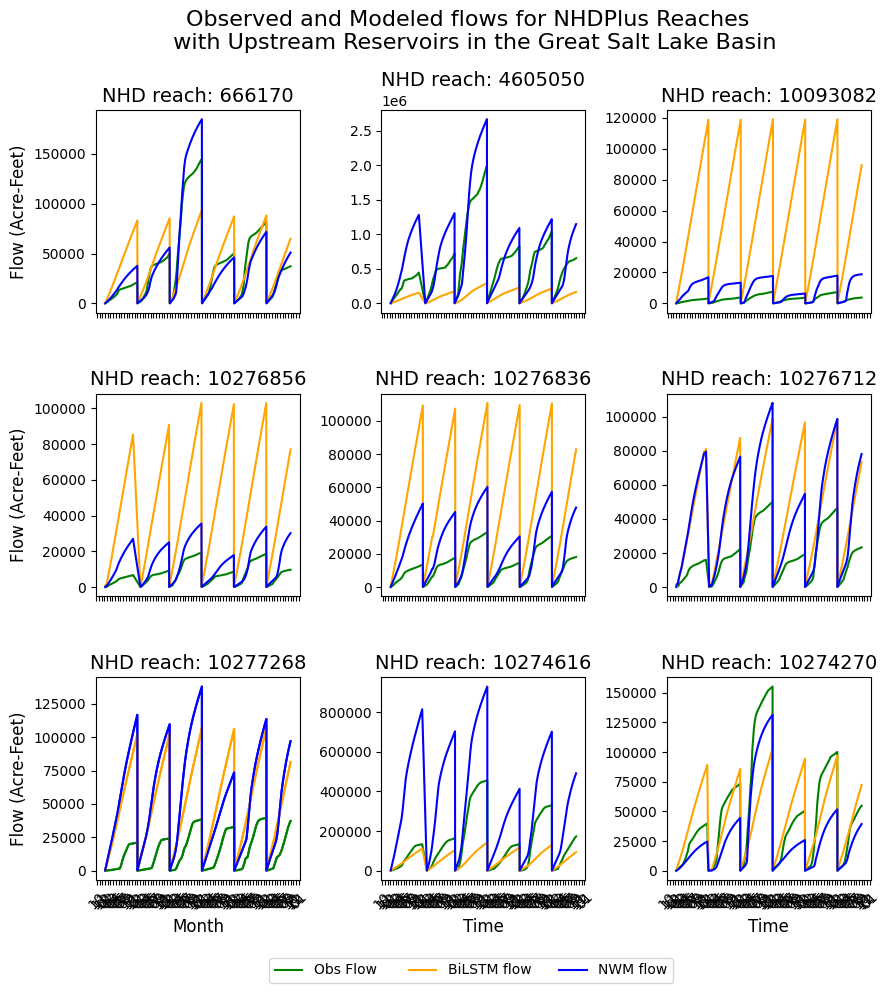

In [40]:
#importlib.reload(s_FigureGenerator)
plotname = 'BiLSTM_TS_plot'
freq = 'D'
supply = True
title = 'Observed and Modeled flows for NHDPlus Reaches \n with Upstream Reservoirs in the Great Salt Lake Basin'
path_figure_1 = f"{path_save_figure}/{plotname}.png"
s_FigureGenerator.TS_plot(best_output, model_name, path_figure_1, title, freq, supply)

In [41]:
#importlib.reload(s_FigureGenerator)
plotname = 'BiLSTM_ParityPlot'
path_figure_2 = f"{path_save_figure}/{plotname}.png"
s_FigureGenerator.Parity_plot(best_output, model_name, path_figure_2)

NameError: name 'importlib' is not defined

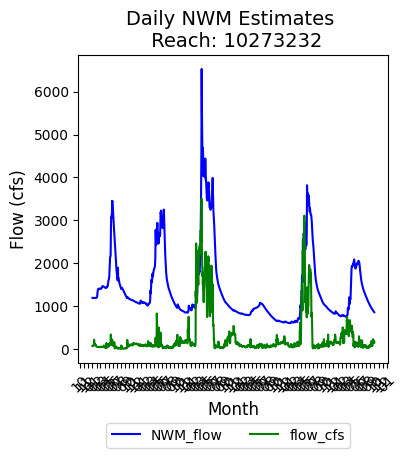

In [33]:
reach = 10273232
variables =['NWM_flow', 'flow_cfs']
colors = ['blue', 'green']
plotname = 'NWMFlow'
path_figure_3 = f"{path_save_figure}/{plotname}.png"
units = 'cfs'
y_lab = f"Flow ({units})"
title = f"Daily NWM Estimates \n Reach: {str(reach)}"

s_FigureGenerator.Var_TS_plot(best_output, reach, variables, colors, model_name,y_lab, path_figure_3, title, units, supply = False)

In [ ]:
import AWS_transfer
state = 'ut'
AWS_transfer.Predictions2AWS(model_name, state)